# Training a JARVIS-ML model

In [64]:
#from jarvis.sklearn.get_desc import get_comp_descp
from monty.serialization import loadfn, MontyDecoder,dumpfn
import numpy as np
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split,learning_curve,cross_val_score,cross_val_predict,GridSearchCV,RandomizedSearchCV
import scipy as sp
import time,os,json,pprint
from sklearn.feature_selection import SelectKBest,f_classif,SelectFromModel,VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Download descriptors and material data from the following link:
#  https://figshare.com/articles/JARVIS-ML-CFID-descriptors_and_material_properties/6870101 

# Websites: https://www.ctcms.nist.gov/jarvisml, https://jarvis.nist.gov
# https://arxiv.org/abs/1805.07325


# NIST-disclaimer: https://www.nist.gov/disclaimer

# Exploring the JSON data

In [8]:
dat_3d=loadfn('jarvisml_cfid.json',cls=MontyDecoder)


In [9]:
# Size of the data
len(dat_3d)

24759

In [5]:
#Available keys

In [10]:
dat_3d[0].keys()

dict_keys(['gv', 'kp_leng', 'form_enp', 'kv', 'hl_mass', 'hl_mass_z', 'magmom', 'hl_mass_y', 'hl_mass_x', 'type', 'encut', 'el_mass_z', 'multi_elastic', 'strt', 'epsy', 'desc', 'el_mass', 'epsz', 'mepsz', 'el_mass_x', 'el_mass_y', 'op_gap', 'mepsy', 'mpid', 'fin_enp', 'jid', 'exfoliation_en', 'epsx', 'mepsx', 'mbj_gap'])

In [11]:
# desc: 1557 descriptors
# form_enp: formation energy per atom (eV/atom)
# op_gap: OptB88vdW functional based bandgap (eV)
# mbj_gap: TBmBJ functional based bandgap (eV)
# kv: Voigt bulk mod. (GPa)
# gv: Shear bulk mod. (GPa)
# elastic: elastic tensor instring format, use the function 'get_et' to convert into pymatgen elastictensor object
# epsx: Static dielctric function value in x-direction based on OptB88vdW (no unit)
# mepsx: Static dielctric function value in x-direction based on TBmBJ (no unit)
# magmom: Magnetic moment (Bohr magneton) [from OUTCAR and from OSZICAR], generally OSZICAR value is preferred
# kp_leng: Kpoint automatic line density obtained after automatic convergence (Angstrom), substract 25 because 5 extra points were taken during convergence
# encut: Plane wave cut-off value obtained after automatic convergence
# exfoliation_en: exfoliation energy
# strt: final structure after relaxation with OptB88vdW
# el/hl_mass: effective mass with BoltzTrap at 300K for electrons/holes
#'na' signifies non-available data

In [12]:
pprint.pprint(dat_3d[0])

{'desc': array([ 4310.55  ,  3193.1684,    10.542 , ...,     8.    ,     0.    ,
           0.    ]),
 'el_mass': [6.023889743488937e-07,
             6.023889743488937e-07,
             6.023889743488937e-07],
 'el_mass_x': 6.023889743488937e-07,
 'el_mass_y': 6.023889743488937e-07,
 'el_mass_z': 6.023889743488937e-07,
 'encut': 600,
 'epsx': 'na',
 'epsy': 'na',
 'epsz': 'na',
 'exfoliation_en': 'na',
 'fin_enp': -2.71548755,
 'form_enp': 0.161,
 'gv': 'na',
 'hl_mass': [6.023889485944474e-07,
             6.023889485944475e-07,
             6.02388948594448e-07],
 'hl_mass_x': 6.023889485944474e-07,
 'hl_mass_y': 6.023889485944475e-07,
 'hl_mass_z': 6.02388948594448e-07,
 'jid': 'JVASP-11946',
 'kp_leng': 90,
 'kv': 'na',
 'magmom': 2.278903,
 'mbj_gap': 'na',
 'mepsx': 'na',
 'mepsy': 'na',
 'mepsz': 'na',
 'mpid': 'mp-1006883',
 'multi_elastic': 'na',
 'op_gap': 0.0015999999999998238,
 'strt': Structure Summary
Lattice
    abc : 2.8018838472201355 2.8018838472201355 2.801883847220

In [13]:
#Avilable data 
keys=['gv','kv','fin_enp','op_gap','mbj_gap','magmom','epsx','epsy','epsz','mepsx','mepsy','mepsz','hl_mass','form_enp','exfoliation_en']
info={}
for i in dat_3d:
  for j in keys:
     if i[j]!='na' and i[j]!={}:
            info.setdefault(j, []).append(i['jid'])
for i,j in info.items():
    print (i,len(j))


fin_enp 24759
mepsy 10560
form_enp 24759
exfoliation_en 564
mepsz 10560
hl_mass 19978
magmom 24759
mepsx 10560
op_gap 22394
mbj_gap 7055


# Pnadas dataframe

In [14]:
jid, opgap, mbjgap, energy,form_energy,magmom, exfen, url =[],[],[],[],[],[],[],[]


In [15]:
for i in dat_3d:
    jid.append(i['jid'])
    opgap.append(i['op_gap'])
    mbjgap.append(i['mbj_gap'])
    magmom.append(i['magmom'])
    energy.append(i['fin_enp'])
    form_energy.append(i['form_enp'])
    exfen.append(i['exfoliation_en'])
    url.append(str("https://www.ctcms.nist.gov/~knc6/jsmol/")+str(i['jid'])+str(".html"))

In [16]:
headers = ['JARVIS_ID','OPT_Gap','MBJ_Gap','Magnetic_moment','Final_Energy','Formation energy','Exfoliation_Energy','URL']

In [17]:
df = pd.DataFrame([jid,opgap,mbjgap,magmom,energy,form_energy,exfen,url])

In [18]:
df = df.transpose()
df.columns = headers

In [19]:
df.head()


,JARVIS_ID,OPT_Gap,MBJ_Gap,Magnetic_moment,Final_Energy,Formation energy,Exfoliation_Energy,URL
0,JVASP-11946,0.0016,na,2.2789,-2.71549,0.161,na,https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-1...
1,JVASP-11947,0.0018,na,5.53084,-3.61931,0.006,na,https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-1...
2,JVASP-11948,0.0019,na,1.53273,-5.85766,-0.014,na,https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-1...
3,JVASP-11949,0.0098,na,0,-0.333393,-0.21,na,https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-1...
4,JVASP-11950,0.0143,na,-0,-2.54869,-0.648,na,https://www.ctcms.nist.gov/~knc6/jsmol/JVASP-1...


# List of helpful functions

In [20]:
#collection of functions
def isfloat(value):
  try:
    float(value)
    return True
  except :
    return False
    pass
#Get data and descriptors for a particular properties
def jdata(data_file='jarvisml_cfid.json',prop=''):
  d3=loadfn(data_file,cls=MontyDecoder)
  X=[]
  Y=[]
  jid=[]
  for ii,i in enumerate(d3):
    y=i[prop]
    if isfloat(y):
      y=float(y)
      x=i['desc']
      if len(x)==1557 and any(np.isnan(x) for x in x.flatten())==False:
        if 'eps' in prop:
          y=np.sqrt(float(y))
        if 'mag' in prop:
           num=get_number_formula_unit(i['strt'])
           y=float(abs(y))/float(num)
        X.append(x)
        Y.append(y)
        jid.append(i['jid'])
  print ('Prop=',prop,len(X),len(Y))
  X=np.array(X).astype(np.float64)
  Y=np.array(Y).astype(np.float64)
  return X,Y,jid

def plot_learning_curve(estimator=None, scoring='neg_mean_absolute_error',title='', X=None, y=None, ylim=None, cv=5,
                        #n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10),fname='fig.png'):
                        n_jobs=n_jobs, train_sizes=np.linspace(.01, 1.0, 50),fname='fig.png'):
    plt.figure()
    #fname='fig.png'
    plt.title(title)
    mem={}
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    mem['train_sizes']=train_sizes
    mem['train_scores_mean']=train_scores_mean
    mem['test_scores_mean']=test_scores_mean
    mem['train_scores_std']=train_scores_std
    mem['test_scores_std']=test_scores_std

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    fname=str(fname)+str('_learn_1.png')
    plt.show()
    plt.savefig(fname)
    plt.close()

    data=str(fname)+str('learn_data')
    f=open(data,'w')
    line=str('train_sizes ')+str('train_scores_mean ')+str('train_scores_std ')+str('test_scores_mean ')+str('test_scores_std ')+'\n'
    f.write(line)
    for i,j,k,l,m in zip(train_sizes,train_scores_mean,train_scores_std,test_scores_mean,test_scores_std):
        line=str(i)+str(' ')+str(j)+str(' ')+str(k)+str(' ')+str(l)+str(' ')+str(m)+str('\n')
        f.write(line)
    f.close()

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    fname=str(fname)+str('_learn_2.png')
    plt.show()
    plt.savefig(fname)
    plt.close()
    return mem

def regr_scores(pred,test):
   rmse=np.sqrt(mean_squared_error(test, pred))
   r2=r2_score(test, pred)
   mae=(mean_absolute_error(test, pred))
   info={}
   info['mae']=mae
   info['rmse']=rmse
   info['r2']=r2
   info['test']=test
   info['pred']=pred
   return info


def get_lgbm(train_x, val_x, train_y,val_y,cv,n_jobs,scoring):
    # Get converged boosting iterations with high learning rate, MAE as the convergence crietria
    lgbm = lgb.LGBMRegressor(
                             n_estimators=1000,
                             learning_rate=0.1,
                             max_depth=5,
                             num_leaves=100,
                             objective='regression',
                             #min_data_in_leaf=2,
                             n_jobs=-1,
                             verbose=-1
                            )

    lgbm.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
        eval_metric='mae',
        #eval_metric='l1',
        early_stopping_rounds=10)
    num_iteration=lgbm.best_iteration_
    print ('num_iteration',num_iteration)
    print ('in randomsearch cv')

    #Generally thousands of randomized search for optimal parameters
    # learning rate and num_leaves are very important
    param_dist = {
                    #'boosting_type': [ 'dart'],
                    #'boosting_type': ['gbdt', 'dart', 'rf'],
                    #'num_leaves': sp.stats.randint(2, 1001),
                    #'subsample_for_bin': sp.stats.randint(10, 1001),
                    #'min_split_gain': sp.stats.uniform(0, 5.0),
                    #'min_child_weight': sp.stats.uniform(1e-6, 1e-2),
                    #'reg_alpha': sp.stats.uniform(0, 1e-2),
                    #'reg_lambda': sp.stats.uniform(0, 1e-2),
                    #'tree_learner': ['data', 'feature', 'serial', 'voting' ],
                    #'application': ['regression_l1', 'regression_l2', 'regression'],
                    #'bagging_freq': sp.stats.randint(1, 11),
                    #'bagging_fraction': sp.stats.uniform(.1, 0.9),
                    #'feature_fraction': sp.stats.uniform(.1, 0.9),
                    #'learning_rate': sp.stats.uniform(1e-3, 0.9),

                    #'est__num_leaves': [2,8,16],
                    #'est__min_data_in_leaf': [1,2,4],
                    #'est__learning_rate': [0.005,0.01,0.1],
                    #'est__max_depth': [1,3,5], #sp.stats.randint(1, 501),
                    #'est__n_estimators': [num_iteration,2*num_iteration,5*num_iteration],#sp.stats.randint(100, 20001),
                    #'gpu_use_dp': [True, False],
                    #'est__num_leaves': sp.stats.randint(3, 1000),
                    #'est__max_depth': sp.stats.randint(1, 5),
                    'est__learning_rate': sp.stats.uniform(1e-3, 0.9),

                 }
    lgbm = lgb.LGBMRegressor(
                             objective='regression',
                             #device='gpu',
                             n_estimators=num_iteration,
                             n_jobs=n_jobs,
                             verbose=-1
                            )
    pipe = Pipeline([
                   ('stdscal', StandardScaler()),
                    ("vart", VarianceThreshold(1e-4)),
                     ('est', lgbm)
                ])

    n_iter=10
    # Increase n_iter
    rscv = RandomizedSearchCV(
                              estimator=pipe,
                              param_distributions=param_dist,
                              cv=cv,
                              scoring=scoring,
                              n_iter=n_iter,
                              n_jobs=n_jobs,
                              verbose=3,
                              refit=True,
                            )
    rscv = rscv.fit(train_x,train_y)
    return rscv.best_estimator_


# Step by ste training 

In [39]:
# Main-function
def run(version='version_1',scoring='neg_mean_absolute_error',cv=5,n_jobs=1,prop='op_gap',do_cv=False):

 name=str(version)+str('_')+str(prop)
 # Make a directory for storing results
 dir_name=str(os.getcwd())+str("/")+str(name)
 if not os.path.exists(dir_name): os.makedirs(dir_name)
 os.chdir(dir_name)



 info={}
 tmp_time=time.time()

 #STEP-1: Data for a particular model

 x,y,jid=jdata(prop=prop)

 # Toy example with boston data
 #boston=load_boston()
 #x, y = boston['data'], boston['target']

 #STEP-2: Splitting the data
 # 90-10% split for train test
 X_train, X_test, y_train, y_test,jid_train,jid_test = train_test_split(x, y,jid, random_state=1, test_size=0.1)

 #further split for boosting iteration convergence
 X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, random_state=1, test_size=0.1)
 print ('lenx len y',len(x[0]),len(y))

 #STEP-3: GBM model with converged iterations

 model=get_lgbm(X_train1, X_test1, y_train1, y_test1,cv,n_jobs,scoring)


 model.fit(X_train,y_train)
 print (model,model.named_steps['est'].n_estimators)
 print ('model',model.__dict__)
 #info['model']=model.__dict__

 #STEP-4: Predict on 10% held data and  accuracy

 pred=model.predict(X_test)
 reg_sc=regr_scores(y_test,pred)

 print ('reg_sc',reg_sc)
 info['reg_sc']=reg_sc
 info['y']=y
 info['time']=time.time()-tmp_time
 info['jid_test']=jid_test

 model.fit(X_train1,y_train1)
 print('Plot feature importances...')

 #STEP-5: Feature importance
 feat_imp = model.named_steps['est'].feature_importances_ #feature_importances_
 feat_imp=np.array([float(i)/float(np.sum(feat_imp)) for i in feat_imp])
 print ('feat_imp',name,feat_imp,len(feat_imp))

 # Since variance threshold removed some features
 keep_indices2=model.named_steps['vart'].get_support(indices=True)
 info['keep_indices_sel']=keep_indices2

 print ('keep_indices2',keep_indices2,len(keep_indices2))

 indices = np.argsort(feat_imp)[::-1]
 xs=feat_imp[indices]
 ys=keep_indices2[indices]

 print ('xs,ys',len(xs),len(ys))
 data_imp=[]
 f=open('feat_names.json','r')
 names=json.load(f)
 f.close()

 for f in range(len(xs)):
   print (f,xs[f],names[ys[f]])
   data_imp.append([f,xs[f],names[ys[f]]])
 info['feature_importance']=data_imp

 #STEP-6: N-fold cross-validation prediction

 scores = cross_val_score(model, x, y, cv=cv,n_jobs=n_jobs,scoring='mean_absolute_error')
 print("MAE-Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
 info['cross_val_scores']=scores

 fname=str(name)+str('-GB-CV.png')
 predicted = cross_val_predict(model, x, y, cv=cv,n_jobs=n_jobs)
 fig, ax = plt.subplots()
 ax.set_xlabel('DFT prediction')
 ax.set_ylabel('ML prediction')
 print ('cv_predicted')
 cvpred={}
 cvpred['cross_val_y']=y
 cvpred['cross_val_predicted']=predicted
 info['cvpredict_result']=cvpred

 ax.scatter(y, predicted, edgecolors=(0, 0, 0))
 plt.savefig(fname)
 plt.close()

 #STEP-7: Plot learning curve

 mem_learn=plot_learning_curve(estimator=model,scoring=scoring,fname=name,title="",X=x, y=y,n_jobs=n_jobs)
 info['learning_curve_data']=mem_learn

 #STEP-8: Store ML parameters with pickle and joblib

 model.fit(x,y)
 filename=str('pickle2-')+str(name)+str('.pk')
 pickle.dump( model, open( filename, "wb" ) )
 filename=str('joblib2-')+str(name)+str('.pkl')
 joblib.dump(model, filename)

 #STEP-9: Store data in a json file

 file=str(name)+'_info.json'
 f=open(file,'w')
 f.write(json.dumps(info,cls=MontyEncoder,indent=4))
 f.close()
 os.chdir('../')

# This may take long time
# run(version='version_1',scoring='neg_mean_absolute_error',cv=5,n_jobs=1,prop='op_gap',do_cv=False)



# Quick ML training example for formation energy

In [21]:
 #or just test fit model 
 model = lgb.LGBMRegressor(
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=5,
                    num_leaves=100,
                    objective='regression',
                    n_jobs=-1,
                    verbose=-1
                   )

In [22]:
x,y,jid=jdata(prop='form_enp')
X_train, X_test, y_train, y_test,jid_train,jid_test = train_test_split(x, y,jid, random_state=1, test_size=0.1)

Prop= form_enp 24759 24759


In [26]:
len(X_train), len(X_test)

(22283, 2476)

In [28]:
#Let's take 500 of training set for quick training example
X=X_train[0:500]
Y=y_train[0:500]

In [31]:
len(X[0])

1557

In [32]:
model.fit(X,Y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=5, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=100, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=-1)

In [33]:
 pred=model.predict(X_test)
 reg_sc=regr_scores(y_test,pred)

In [34]:
reg_sc

{'mae': 0.30159100777069109,
 'pred': array([-1.397, -1.619, -1.903, ..., -0.074, -0.966, -3.005]),
 'r2': 0.79593580543372378,
 'rmse': 0.41913838982329049,
 'test': array([-1.99505582, -2.06487988, -1.70864231, ..., -0.57396132,
        -1.0390673 , -1.46455951])}

# Visualization with manifold t-SNE

In [45]:
from sklearn import decomposition,manifold
pca = decomposition.PCA(n_components=30)
Z_pca = pca.fit_transform(X)

# note: scikit-learn docs are incorrect when they state that perplexity isn't an important hyperparameter...
sne = manifold.TSNE(perplexity=100, verbose=True)
sne.fit(Z_pca)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 714.524558
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.260345
[t-SNE] Error after 175 iterations: 0.260345


TSNE(angle=0.5, early_exaggeration=4.0, init='random', learning_rate=1000.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=30, perplexity=100,
   random_state=None, verbose=True)

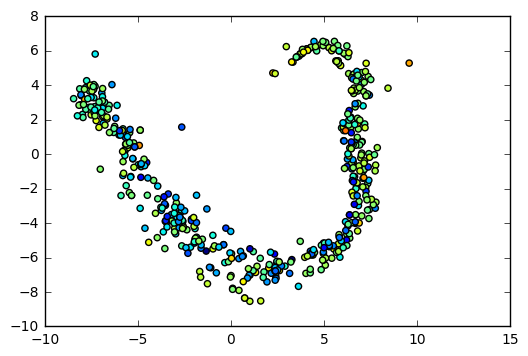

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(sne.embedding_[:,0],sne.embedding_[:,1],c=Y)
plt.show()